In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import tensorflow as tf
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# repeating the data prep from the previous notebook
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
# EDIT: splitting training data into train and val because this is better practice than using test data to
# choose models/hyperparameters
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)

x_train = x_train.astype(numpy.float32)
# EDIT: adding pre-processing to validation data 
x_val  = x_val.astype(numpy.float32)
x_test  = x_test.astype(numpy.float32)

x_train /= 255.
x_val  /= 255.
x_test  /= 255.

print(x_train.shape)
x_train = x_train.reshape(x_train.shape[0], numpy.prod(x_train[0,:,:].shape))
x_val = x_val.reshape(x_val.shape[0], numpy.prod(x_val[0,:,:].shape))
x_test = x_test.reshape(x_test.shape[0], numpy.prod(x_test[0,:,:].shape))

print(x_train.shape)
y_train = y_train.astype(numpy.int32)
y_val  = y_val.astype(numpy.int32)
y_test  = y_test.astype(numpy.int32)

print()
print('MNIST data loaded: train:',len(x_train),'val:',len(x_val), 'test:',len(x_test))
print('X_train:', x_train.shape)
print('y_train:', y_train.shape)

# one-hot encoding:
nb_classes = 10
y_train_onehot = tf.keras.utils.to_categorical(y_train, nb_classes)
y_val_onehot = tf.keras.utils.to_categorical(y_val, nb_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, nb_classes)

(40200, 28, 28)
(40200, 784)

MNIST data loaded: train: 40200 val: 19800 test: 10000
X_train: (40200, 784)
y_train: (40200,)


In [ ]:
# Here we import an implementation of a two-layer neural network 
# this code is based on pieces of the first assignment from Stanford's CSE231n course, 
# hosted at https://github.com/cs231n/cs231n.github.io with the MIT license
from fc_net import TwoLayerNet

In [ ]:
# a simple implementation of stochastic gradient descent
def sgd(model, gradients, learning_rate):
    for p, w in model.params.items():
        dw = gradients[p]
        new_weights = w - learning_rate * dw
        model.params[p] = new_weights

In [ ]:
# one training step
def learn(model, x_train, y_train_onehot, learning_rate):
    loss, gradients = model.loss(x_train, y_train_onehot)
    sgd(model, gradients, learning_rate)
    return loss

In [ ]:
def accuracy(model, x, true_values):
    scores = model.loss(x)
    predictions = numpy.argmax(scores, axis=1)
    N = predictions.shape[0]
    # EDIT: squeezing true_values from 2d to 1d speeds up this function
    true_values_1d = numpy.squeeze(true_values)
    acc = (true_values_1d == predictions).sum() / N
    return acc

In [ ]:
# EDIT: decided to track how long each epoch takes
import time

In [ ]:
# Here's an example training loop using this two-layer model. Can you do better? 

# EDIT: also track validation data
# EDIT: factoring this out into a function to make it easier to compare options
def training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot):
    num_features = x_train.shape[1] # this is the number of pixels
    nb_classes = y_train_onehot.shape[1]
    
    # The weights are initialized from a normal distribution with standard deviation weight_scale
    model = TwoLayerNet(input_dim=num_features, hidden_dim=hidden_dim, num_classes=nb_classes, weight_scale=weight_scale)
    
    num_examples_train = x_train.shape[0]
    num_batches_train = int(num_examples_train / batch_size)
    
    losses = numpy.zeros((num_batches_train*num_epochs,2)) # 1st column for training data, 2nd for validation data
    # EDIT: also track accuracy
    accuracies = numpy.zeros((num_batches_train*num_epochs,2)) 
    
    indices_train = numpy.arange(num_examples_train)
    num_examples_val = x_val.shape[0]
    indices_val = numpy.arange(num_examples_val)

    i = 0
    for epoch in range(0, num_epochs):
        start_epoch = time.time()
        # in each epoch, we loop over all of the training examples
        for step in range(0, num_batches_train):
            # grabbing the next training batch
            offset_train = step * batch_size
            batch_range_train = range(offset_train, offset_train+batch_size)
            x_train_batch = x_train[batch_range_train, :]
            # EDIT: keep around non-onehot labels as well for accuracy calculation
            y_train_onehot_batch = y_train_onehot[batch_range_train,:]
            y_train_batch = y_train[batch_range_train,numpy.newaxis]

            # one approach: grab a random validation batch (random offset into number of validation examples)
            offset_val = numpy.random.randint(low=0, high=num_examples_val-batch_size)
            batch_range_val = range(offset_val, offset_val+batch_size)
            x_val_batch = x_val[batch_range_val, :]
            y_val_onehot_batch = y_val_onehot[batch_range_val,:]
            y_val_batch = y_val[batch_range_val,numpy.newaxis]

            # feed the next batch in to do one sgd step
            loss_train = learn(model, x_train_batch, y_train_onehot_batch, learning_rate)

            # check training & validation loss & accuracy
            losses[i,0] = loss_train
            
            # could save time by commenting out the next three lines and only tracking at the epoch level
            accuracies[i,0] = accuracy(model, x_train_batch, y_train_batch)
            losses[i,1], _ = model.loss(x_val_batch, y_val_onehot_batch)
            accuracies[i,1] = accuracy(model, x_val_batch, y_val_batch)
            i += 1

        # slower, so we're only doing this once per epoch: checking accuracy on all of the data at once
        acc_train = accuracy(model, x_train, y_train)
        acc_val = accuracy(model, x_val, y_val)
        
        # reshuffle the data so that we get a new set of batches
        numpy.random.shuffle(indices_train)
        x_train = x_train[indices_train,:]
        y_train = y_train[indices_train] # keep this shuffled the same way for use in accuracy calculation
        y_train_onehot = y_train_onehot[indices_train,:]

        numpy.random.shuffle(indices_val)
        x_val = x_val[indices_val,:]
        y_val = y_val[indices_val] 
        y_val_onehot = y_val_onehot[indices_val,:]
        end_epoch = time.time()
        time_this_epoch = end_epoch - start_epoch
        print("epoch %d took %.1f seconds, training loss %.5f (last batch), training accuracy %.3f, validation accuracy %.3f" % (epoch, time_this_epoch, loss_train, acc_train, acc_val))
    return losses, accuracies, model

        

**Changing number of epochs to 10 to see changes in the accuracy and loss**

0.03210479558034334
epoch 0 took 49.5 seconds, training loss 0.68331 (last batch), training accuracy 0.849, validation accuracy 0.847
epoch 1 took 26.9 seconds, training loss 0.49531 (last batch), training accuracy 0.877, validation accuracy 0.877
epoch 2 took 26.2 seconds, training loss 0.41645 (last batch), training accuracy 0.889, validation accuracy 0.889
epoch 3 took 25.4 seconds, training loss 0.38899 (last batch), training accuracy 0.896, validation accuracy 0.899
epoch 4 took 26.1 seconds, training loss 0.37669 (last batch), training accuracy 0.902, validation accuracy 0.904
epoch 5 took 25.9 seconds, training loss 0.32908 (last batch), training accuracy 0.906, validation accuracy 0.908
epoch 6 took 26.6 seconds, training loss 0.31772 (last batch), training accuracy 0.910, validation accuracy 0.913
epoch 7 took 25.9 seconds, training loss 0.34562 (last batch), training accuracy 0.913, validation accuracy 0.915
epoch 8 took 26.8 seconds, training loss 0.30405 (last batch), train

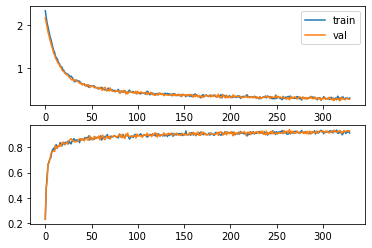

In [ ]:

learning_rate = 0.1  
batch_size = 1200#1200
num_epochs = 10
hidden_dim = 1600#1600
size_input = x_train.shape[1]
weight_scale1 = numpy.sqrt(2./(size_input+hidden_dim))
weight_scale2 = numpy.sqrt(2./(hidden_dim+nb_classes))
weight_scale = (weight_scale1 + weight_scale2)/2
print(weight_scale)
losses, accuracies, model = training(learning_rate, batch_size, num_epochs, hidden_dim, weight_scale, x_train, y_train, y_train_onehot, x_val, y_val, y_val_onehot)

plt.figure()
plt.subplot(2,1,1)
plt.plot(losses[:,0])
plt.plot(losses[:,1])
plt.legend(["train", "val"])

plt.subplot(2,1,2)
plt.plot(accuracies[:,0])
plt.plot(accuracies[:,1])

**Accuracy improved from 85% to 92%**
